<a href="https://colab.research.google.com/github/Bartolomeo0609/Colab/blob/main/Neuralnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction to neural nets

En este cuaderno exploraremos un poco el uso de redes neuronales. La tarea será consutrir una red utilizando sklearn y otra utilizando TensorFlow, para atacar el problema del dataset [notMNIST](http://yaroslavvb.com/upload/notMNIST/).

In [ ]:
import os
import sys
import random
import tarfile

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy import ndimage
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from urllib.request import urlretrieve

El siguiente código se encarga de organizar todo lo que necesitamos para trabajar

In [ ]:
URL = 'http://yaroslavvb.com/upload/notMNIST/'
NUM_CLASSES = 10
IMAGE_SIZE = 28
PIXEL_MAX_VALUE = 255.0

In [ ]:
def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(URL + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception(
        'Failed to verify' + filename + '. Can you get to it with a browser?')
    return filename

In [ ]:
train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)

Found and verified notMNIST_large.tar.gz


In [ ]:
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_small.tar.gz


In [ ]:
def extract(filename):
    tar = tarfile.open(filename)
    root = os.path.splitext(os.path.splitext(filename)[0])[0] # remove .tar.gz
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
    data_folders = [os.path.join(root, d)
                    for d in sorted(os.listdir(root))
                    if d != '.DS_Store']
    if len(data_folders) != NUM_CLASSES:
        raise Exception(
            'Expected %d folders, one per class. Found %d instead.' % (
                num_classes, len(data_folders)))
    print(data_folders)
    return data_folders

In [ ]:
train_folders = extract(train_filename)
test_folders = extract(test_filename)

Extracting data for notMNIST_large. This may take a while. Please wait.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
Extracting data for notMNIST_small. This may take a while. Please wait.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


In [ ]:
def load(data_folders, min_num_images, max_num_images):
    dataset = np.ndarray(shape=(max_num_images, IMAGE_SIZE, IMAGE_SIZE), dtype=np.float32)
    labels = np.ndarray(shape=(max_num_images), dtype=np.int32)
    label_index = 0
    image_index = 0
    for folder in data_folders:
        print(folder)
        for image in os.listdir(folder):
            if image_index >= max_num_images:
                raise Exception('More images than expected: %d >= %d' % (
                            image_index, max_num_images))
            image_file = os.path.join(folder, image)
            try:
                image_data = (ndimage.imread(image_file).astype(float) -
                                PIXEL_MAX_VALUE / 2) / PIXEL_MAX_VALUE
                if image_data.shape != (IMAGE_SIZE, IMAGE_SIZE):
                    raise Exception('Unexpected image shape: %s' % str(image_data.shape))
                dataset[image_index, :, :] = image_data
                labels[image_index] = label_index
                image_index += 1
            except IOError as e:
                print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
        label_index += 1
    num_images = image_index
    dataset = dataset[0:num_images, :, :]
    labels = labels[0:num_images]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' % (
            num_images, min_num_images))
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    print('Labels:', labels.shape)
    return dataset, labels

In [ ]:
train_dataset, train_labels = load(train_folders, 450000, 550000)

notMNIST_large/A
Could not read: notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
notMNIST_large/B
Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
notMNIST_large/C
notMNIST_large/D
Could not read: notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png : cannot identify image file 'notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png' - it's ok, skipping.
notMNIST_large/E
notMNIST_large/F
notMNIST_large/G
notMNIST_large/H


In [ ]:
test_dataset, test_labels = load(test_folders, 18000, 20000)

notMNIST_small/A
Could not read: notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png : cannot identify image file 'notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png' - it's ok, skipping.
notMNIST_small/B
notMNIST_small/C
notMNIST_small/D
notMNIST_small/E
notMNIST_small/F
Could not read: notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png : cannot identify image file 'notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png' - it's ok, skipping.
notMNIST_small/G
notMNIST_small/H
notMNIST_small/I
notMNIST_small/J
Full dataset tensor: (18724, 28, 28)
Mean: -0.07463625
Standard deviation: 0.45862198
Labels: (18724,)


In [ ]:
def show_processed_random(dataset,labels,n):
    indices=random.sample(range(0,labels.shape[0]),n)
    fig=plt.figure()
    for i in range(n):
        a=fig.add_subplot(1,n,i+1)
        plt.imshow(dataset[indices[i],:,:])
        a.set_title(chr(labels[indices[i]]+ord('A')))
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
    plt.show()

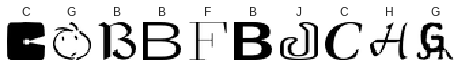

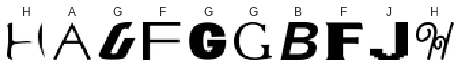

In [ ]:
show_processed_random(train_dataset,train_labels,10)
show_processed_random(test_dataset,test_labels,10)

In [ ]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

In [ ]:
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

In [ ]:
print(train_labels.shape)
print(test_labels.shape)

(529114,)
(18724,)


In [ ]:
print(train_dataset.shape)
print(test_dataset.shape)

(529114, 28, 28)
(18724, 28, 28)


Ya que tenemos nuestras imágenes cargadas, podemos empezar a trabajar. Lo primero que debemos hacer es que cada pixel represente una característica diferente, es decir, debemos cambiar el tamaño del dataset de `(n_imgs, IMAGE_SIZE, IMAGE_SIZE)` por `(n_imgs, IMAGE_SIZE * IMAGE_SIZE)`.

**Ejercicio 0:** cambia la forma de `train_dataset` y `test_dataset` utilizando [`np.reshape`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html).

In [ ]:
train_dataset = np.reshape (n_imgs, IMAGE_SIZE * IMAGE_SIZE)

NameError: ignored

In [ ]:
test_dataset = np.reshape

In [ ]:
print(train_dataset.shape)
print(test_dataset.shape)

AttributeError: ignored

Como siempre es importante tener un modelo base, que nos permita observar si agregarle complejidad al modelo sirve de algo.

In [ ]:
lr = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=10)
lr.fit(train_dataset, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [ ]:
lr.score(test_dataset, test_labels)

0.8965498825037386

Ahora miremos el resultado de una red neuronal usando la clase [`MLPClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) de scikit-learn.

**Ejercicio 1:** construye una red neuronal con 100 nodos en la primera capa oculta y 50 en la segunda. Utiliza la función de activación relu y un máximo de 10 *epochs*.

In [ ]:
nn =
nn.fit(train_dataset, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [ ]:
nn.score(test_dataset, test_labels)

0.956419568468276